Loaded 63616 geo features.
After filtering empty AGEBs: 61226 features.
Numeric coercion complete—NaNs handled for non-numeric values.
Weights loaded: {'education': 0.3, 'employment': 0.25, 'poverty_goods': 0.2, 'housing_quality': 0.1, 'services_access': 0.15, 'overcrowding': -0.1, 'marginalization': -0.05, 'dependency': -0.05, 'female_headed': -0.04, 'gender_balance': -0.04}


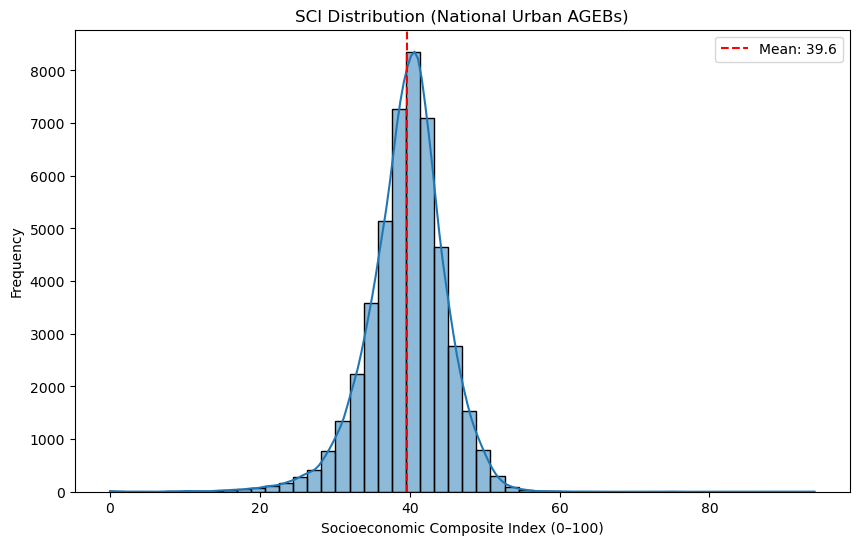


=== SCI Statistics by State ===
State 1 (Aguascalientes): 29.000634211025844–53.99878121026729 (mean 40.95382528812846)
State 2 (Baja California): 21.590572902118417–53.69124308628292 (mean 42.249726545549144)
State 3 (Baja California Sur): 17.297856908753058–58.117640560886116 (mean 42.409878535752405)
State 4 (Campeche): 24.292748850071575–53.32688117449057 (mean 40.78977449272836)
State 5 (Coahuila de Zaragoza): 9.156404244144332–55.028822639904476 (mean 39.07918796159158)
State 6 (Colima): 23.884797538730776–51.687197485765424 (mean 40.96618955717694)
State 7 (Chiapas): 8.805777883348352–55.77464756947524 (mean 35.597418825181315)
State 8 (Chihuahua): 24.36506736013642–54.80281408902358 (mean 40.95826090595589)
State 9 (Ciudad de México): 4.247232634218978–94.03661610508125 (mean 43.73540143972535)
State 10 (Durango): 13.908522844704013–74.27224090786156 (mean 38.49098971915196)
State 11 (Guanajuato): 11.606626766616104–60.45368734584679 (mean 39.119607087929246)
State 12 (Guerrer

In [14]:
import pandas as pd
import yaml
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load merged GeoParquet
geo_path = '../data/processed/ageb_merged/national_ageb_geo.parquet'
ageb_geo = gpd.read_parquet(geo_path)

print(f"Loaded {len(ageb_geo)} geo features.")

# Filter out empty AGEBs (POBTOT = 0 or NaN) to avoid 0.0 SCI scores
ageb_geo = ageb_geo[ageb_geo['POBTOT'] > 0].copy()
print(f"After filtering empty AGEBs: {len(ageb_geo)} features.")

# Coerce numeric types for all proxy vars and denoms (fixes str division error)
all_vars = [
    'GRAPROES', 'P15YM_AN', 'P18YM_PB', 'POCUPADA', 'VPH_REFRI', 'VPH_PC', 'VPH_AUTOM', 'VPH_LAVAD',
    'VPH_PISODT', 'VPH_AGUADV', 'VPH_C_ELEC', 'VPH_DRENAJ', 'VPH_TELEF', 'PRO_OCUP_C', 'P3YM_HLI',
    'POB0_14', 'POB65_MAS', 'HOGJEF_F', 'REL_H_M'
]
denoms = ['P_15YMAS', 'P_12YMAS', 'TVIVHAB', 'TOTHOG', 'POBTOT', 'P_3YMAS', 'P_18YMAS']

numeric_cols = all_vars + denoms
for col in numeric_cols:
    if col in ageb_geo.columns:
        ageb_geo[col] = pd.to_numeric(ageb_geo[col], errors='coerce')

print("Numeric coercion complete—NaNs handled for non-numeric values.")

# Load weights from YAML
with open('../config/weights.yaml', 'r') as f:
    weights = yaml.safe_load(f)

print("Weights loaded:", weights)

# Expanded proxies (18 total, from dictionary CSV)
proxies = {
    'education': ['GRAPROES', 'P15YM_AN', 'P18YM_PB'],  # Avg years, % illiterate (inverse), % post-basic
    'employment': ['POCUPADA'],  # % occupied
    'poverty_goods': ['VPH_REFRI', 'VPH_PC', 'VPH_AUTOM', 'VPH_LAVAD'],  # % fridge, PC, car, washer
    'housing_quality': ['VPH_PISODT'],  # % non-dirt floors
    'services_access': ['VPH_AGUADV', 'VPH_C_ELEC', 'VPH_DRENAJ', 'VPH_TELEF'],  # % water, elec, drainage, phone
    'overcrowding': ['PRO_OCUP_C'],  # ppl/room (inverse)
    'marginalization': ['P3YM_HLI'],  # % indigenous (inverse)
    'dependency': ['POB0_14', 'POB65_MAS'],  # % youth (inverse), % elderly (inverse)
    'female_headed': ['HOGJEF_F'],  # % female-led (inverse)
    'gender_balance': ['REL_H_M']  # Sex ratio deviation (inverse)
}

# Function for category composite (% calcs where needed)
def compute_proxy(row, vars, denom=None):
    vals = []
    for var in vars:
        if var in row and pd.notna(row[var]):
            if denom and denom in row and pd.notna(row[denom]) and row[denom] != 0:
                vals.append(row[var] / row[denom] * 100)  # % calc
            else:
                vals.append(row[var])
    return pd.Series(vals).mean(skipna=True) if vals else pd.NA

# Compute raw proxies (add columns)
for cat, vars in proxies.items():
    denom = 'P_15YMAS' if cat == 'education' else 'P_12YMAS' if cat == 'employment' else 'TVIVHAB' if cat in ['poverty_goods', 'housing_quality', 'services_access'] else 'TOTHOG' if cat == 'female_headed' else 'POBTOT' if cat == 'dependency' else 'P_3YMAS' if cat == 'marginalization' else None
    ageb_geo[f'{cat}_raw'] = ageb_geo.apply(lambda row: compute_proxy(row, vars, denom), axis=1)

# Normalize to 0–1 (higher better)
for cat in proxies:
    raw_col = f'{cat}_raw'
    if raw_col in ageb_geo.columns:
        series = ageb_geo[raw_col].dropna()
        if len(series) > 0:
            if cat in ['overcrowding', 'marginalization', 'dependency', 'female_headed', 'gender_balance']:
                if cat == 'gender_balance':
                    # Deviation from 100 (ideal ratio)
                    ageb_geo[f'{cat}_norm'] = 1 - (np.abs(ageb_geo[raw_col] - 100) / 100)
                else:
                    ageb_geo[f'{cat}_norm'] = 1 / (1 + ageb_geo[raw_col])  # Inverse
            else:
                ageb_geo[f'{cat}_norm'] = ageb_geo[raw_col] / series.max()  # Min-max (use non-NaN max)
        else:
            ageb_geo[f'{cat}_norm'] = 0  # Fallback if all NaN

# Compute SCI: Weighted sum *100, clip 0–100
sci_cols = [f'{cat}_norm' for cat in proxies]
ageb_geo['SCI'] = (
    sum(ageb_geo[col] * weights.get(cat, 0) for col, cat in zip(sci_cols, proxies.keys())) * 100
).clip(0, 100).round(2)

# Quick viz: SCI histogram
plt.figure(figsize=(10, 6))
sns.histplot(ageb_geo['SCI'].dropna(), bins=50, kde=True)
plt.title('SCI Distribution (National Urban AGEBs)')
plt.xlabel('Socioeconomic Composite Index (0–100)')
plt.ylabel('Frequency')
plt.axvline(ageb_geo['SCI'].mean(), color='red', linestyle='--', label=f'Mean: {ageb_geo["SCI"].mean():.1f}')
plt.legend()
plt.show()

# Print SCI range and mean for all 32 states (grouped by ENTIDAD)
state_stats = ageb_geo.groupby(['ENTIDAD', 'NOM_ENT'])['SCI'].agg(['min', 'max', 'mean']).round(1)
state_stats.columns = ['Min', 'Max', 'Mean']

print("\n=== SCI Statistics by State ===")
for (ent, nom_ent), row in state_stats.iterrows():
    print(f"State {ent} ({nom_ent}): {row['Min']}–{row['Max']} (mean {row['Mean']})")

# Export SCI-enriched GeoDataFrame
output_path = '../data/processed/indices/sci_national.parquet'
ageb_geo.to_parquet(output_path, index=False)
print(f"Exported SCI to {output_path} (shape: {ageb_geo.shape}).")